## Training with Pre-trained models
Authors:
- Mario Izquierdo
- Martín Romero

In this notebook we are going to experiment with pre-trained models to solve the proposed image classification problem. Specifically in this notebook we are going to experiment with the MobileNet pretrained network. The way the model will be trained will be using fine-tuning, that consists of unfreezing a few of the top layers of a frozen model base used for feature extraction.

In [1]:
import keras
from keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import csv
import tensorflow as tf
import matplotlib.pyplot as plt

2024-03-05 19:41:38.922592: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 19:41:38.949416: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 19:41:38.949439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 19:41:38.950095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 19:41:38.954595: I tensorflow/core/platform/cpu_feature_guar

### Load dataset

We load the images from our dataset to create the train, validation and test sets. In this case we wanted to use an image size of (180,180) due to the limited computational capacity of our computer, but finalley we used (192,192) due to MobileNet requirements (the size must be squared).

In [2]:
img_size = 192
image_size = (img_size, img_size)
img_tensor_shape = (img_size, img_size, 3)
batch_size = 32
train_dataset = image_dataset_from_directory(
    '../data/new_data/train',
    image_size = image_size,
    batch_size = batch_size)
test_dataset = image_dataset_from_directory(
    '../data/new_data/test',
    image_size = image_size,
    batch_size=batch_size)
val_dataset = image_dataset_from_directory(
    '../data/new_data/validation',
    image_size = image_size,
    batch_size=batch_size)

Found 10778 files belonging to 5 classes.


2024-03-05 19:41:40.502771: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 19:41:40.524223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 19:41:40.524382: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 1497 files belonging to 5 classes.
Found 2696 files belonging to 5 classes.


## Using MobileNet model

In [3]:
conv_base = keras.applications.MobileNet(
    weights="imagenet",
    include_top=False,
    input_shape=(192, 192, 3))

### Unfreezing a few top layers

In [4]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### Creating the model
We added to the pretrained model, a final layer with Dropout, to adapt the network to our problem

In [5]:
inputs = keras.Input(shape=(192, 192, 3))
x = keras.applications.mobilenet.preprocess_input(inputs) 
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#### Fitting the model

In [6]:
# Fine-tuning the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])
  
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/fine_tuning_MobileNet.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30, 
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/30


2024-03-05 19:41:43.178806: I external/local_xla/xla/service/service.cc:168] XLA service 0x55cdfa61d700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 19:41:43.179046: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 with Max-Q Design, Compute Capability 7.5
2024-03-05 19:41:43.230234: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-05 19:41:43.550918: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-05 19:41:49.532343: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-05 19:41:49.532

  4/337 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.2376 - loss: 5.0958

I0000 00:00:1709664111.112186   20887 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1709664111.124059   20887 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7746 - loss: 1.1097

2024-03-05 19:42:10.587190: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-05 19:42:10.587216: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-05 19:42:10.709492: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.27GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-05 19:42:10.709510: W external/local_tsl/tsl/framework/bfc_

337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7749 - loss: 1.1082

W0000 00:00:1709664132.163991   20894 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1709664133.314368   20887 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


337/337 ━━━━━━━━━━━━━━━━━━━━ 38s 86ms/step - accuracy: 0.7751 - loss: 1.1067 - val_accuracy: 0.9625 - val_loss: 0.1803
Epoch 2/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.9547 - loss: 0.2096 - val_accuracy: 0.9681 - val_loss: 0.1679
Epoch 3/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.9692 - loss: 0.1200 - val_accuracy: 0.9636 - val_loss: 0.1882
Epoch 4/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.9770 - loss: 0.0995 - val_accuracy: 0.9692 - val_loss: 0.1770
Epoch 5/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.9846 - loss: 0.0587 - val_accuracy: 0.9726 - val_loss: 0.1646
Epoch 6/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.9869 - loss: 0.0460 - val_accuracy: 0.9718 - val_loss: 0.1715
Epoch 7/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.9939 - loss: 0.0213 - val_accuracy: 0.9737 - val_loss: 0.1709
Epoch 8/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.9939 - loss: 0.0194 - val_accurac

In [7]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Accuracy: ', test_acc)

47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.9812 - loss: 0.0746
Accuracy:  0.9786239266395569


W0000 00:00:1709664658.053779   20887 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Plotting results
We plot the evolution of the accuracy (in training and validation) and the evolution of the loss (in training and validation)

In [8]:
#Function to plot the results
def plot(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(accuracy) + 1)

    plt.plot(epochs, accuracy, "b-o", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r-o", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, "b-o", label="Training loss")
    plt.plot(epochs, val_loss, "r-o", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

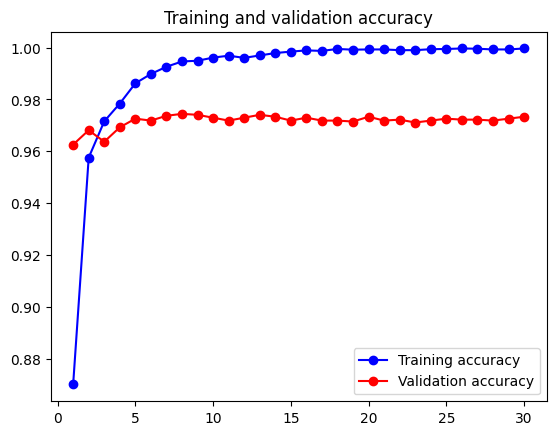

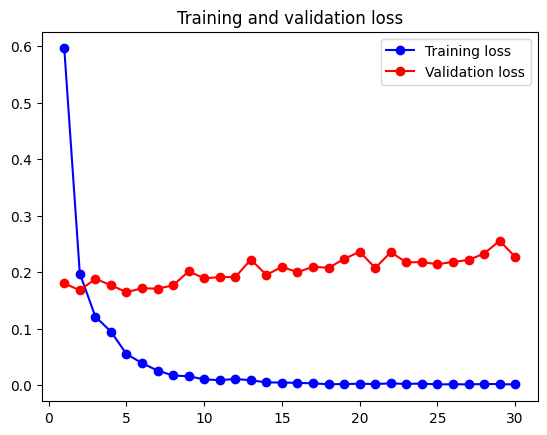

In [9]:
plot(history)

After seeing the results of the network, we see that a good result is obtained, exceeding 90% accuracy. We also see that this percentage is reached after a few training periods and then during all the remaining periods the accuracy remains quite similar.

### Saving the results in a .csv

In [10]:
val_loss, val_acc = model.evaluate(val_dataset)

85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9793 - loss: 0.2030


In [11]:
import os

def save_model_results(file_path, model_name, accuracy):
    """
    This function saves the model's accuracy to a CSV file. It checks if the file exists
    to add a header if necessary and then opens the file in append mode to add
    the model name and accuracy.
    """
    # Check if the file exists to decide on adding the header
    header_needed = not os.path.isfile(file_path)
    # Open the file in append mode, which creates the file if it doesn't exist
    with open(file_path, "a") as file:
        # Add a header if the file was just created
        if header_needed:
            file.write("model_name,accuracy\n")
        # Append the model name and accuracy to the file
        file.write(f"{model_name},{accuracy:.3f}\n")
    

In [12]:
save_model_results('val_results.csv', 'preTrained_FineTuning_MobileNet', val_acc)
save_model_results('test_results.csv', 'preTrained_FineTuning_MobileNet', test_acc)